## Lab assignment 02

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [38]:
#!pip install -U torch==1.10 torchtext torchvision

In [39]:
import torch
torch.__version__

'1.9.0+cpu'

In [40]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

#! pip  install subword-nmt
#! pip install nltk
#! pip install torchtext

In [41]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = 'data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc

In [42]:
!ls

"ls" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [43]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator
#from torchtext.legacy.datasets import TranslationDataset, Multi30k
#from torchtext.legacy.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


In [44]:
from nltk.translate.bleu_score import corpus_bleu
import tqdm

### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [45]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [46]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

#dataset = torchtext.legacy.data.TabularDataset(
dataset = torchtext.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [47]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [48]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 35558
Number of validation examples: 2223
Number of testing examples: 6667


In [49]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [50]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 8525
Unique tokens in target (en) vocabulary: 6177


Here are tokens from original (RU) corpus:

In [51]:
SRC.vocab.itos[::1000]

['<unk>',
 'прекрасно',
 'верхнем',
 'окружающем',
 'сиена',
 'кочин',
 'луанг',
 'альберобелло',
 'польенса']

And from target (EN) corpus:

In [52]:
TRG.vocab.itos[::1000]

['<unk>',
 'specialties',
 'residencial',
 'vehicle',
 'anaheim',
 'buri',
 'successful']

And here is example from train dataset:

In [53]:
print(vars(train_data.examples[9]))

{'trg': ['king', 'royal', 'garden', 'inn', 'is', 'just', 'one', 'skytrain', 'station', 'away', 'from', 'the', 'chao', 'phraya', 'river', ',', 'and', 'a', '10', '-', 'minute', 'skytrain', 'journey', 'from', 'siam', 'square', '.'], 'src': ['отель', 'king', 'royal', 'garden', 'inn', 'расположен', 'в', 'одной', 'остановке', 'наземного', 'метро', 'от', 'реки', 'чао', 'прайя', ',', 'и', 'в', '10', '-', 'ти', 'минутах', 'езды', 'на', 'метро', 'от', 'торгового', 'центра', 'siam', 'square', '.']}


Let's check the length distributions:

Length distribution in Train data


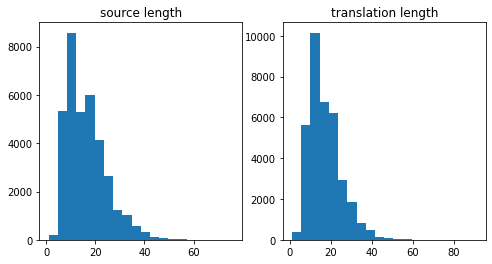

In [54]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


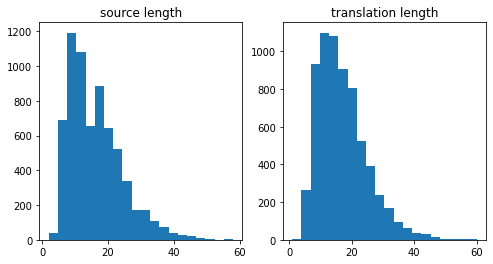

In [55]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [56]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [57]:
device

device(type='cpu')

In [58]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [59]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)
print(x.src)
print(x.trg)


[torchtext.data.batch.Batch of size 128]
	[.trg]:[torch.LongTensor of size 54x128]
	[.src]:[torch.LongTensor of size 50x128]
torch.Size([50, 128]) torch.Size([54, 128])
tensor([[  2,   2,   2,  ...,   2,   2,   2],
        [261,   5,  13,  ...,   5, 646,   5],
        [  0, 408,  31,  ..., 120, 471, 544],
        ...,
        [  1,   1,   1,  ...,   1,   1,   1],
        [  1,   1,   1,  ...,   1,   1,   1],
        [  1,   1,   1,  ...,   1,   1,   1]])
tensor([[   2,    2,    2,  ...,    2,    2,    2],
        [ 145,   26, 3446,  ...,    6,   40,    6],
        [   0,  146,   28,  ...,   62,  128,  153],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]])


In [60]:
x.trg.shape

torch.Size([54, 128])

In [61]:
x.trg[0,:].shape

torch.Size([128])

In [62]:
TRG.vocab.itos[x.trg[16,:][0]]

'<eos>'

In [63]:

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
#         self.dropout = dropout
        
        self.embedding = nn.Embedding(
            num_embeddings=input_dim,
            embedding_dim=emb_dim
        )
            # <YOUR CODE HERE>
        
        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout
        )
            # <YOUR CODE HERE>
        
        self.dropout = nn.Dropout(p=dropout)# <YOUR CODE HERE>
        
    def forward(self, src):
        
        #src = [src sent len, batch size]
        
        # Compute an embedding from the src data and apply dropout to it
        embedded = self.embedding(src)# <YOUR CODE HERE>
        
        embedded = self.dropout(embedded)
        
        output, (hidden, cell) = self.rnn(embedded)
        #embedded = [src sent len, batch size, emb dim]
        
        # Compute the RNN output values of the encoder RNN. 
        # outputs, hidden and cell should be initialized here. Refer to nn.LSTM docs ;)
        
        # <YOUR CODE HERE> 
        
        #outputs = [src sent len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell

In [64]:

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(
            num_embeddings=output_dim,
            embedding_dim=emb_dim
        )
            # <YOUR CODE HERE>
        
        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout
        )
            # <YOUR CODE HERE>
        
        self.out = nn.Linear(
            in_features=hid_dim,
            out_features=output_dim
        )
            # <YOUR CODE HERE>
        
        self.dropout = nn.Dropout(p=dropout)# <YOUR CODE HERE>
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        # Compute an embedding from the input data and apply dropout to it
        embedded = self.dropout(self.embedding(input))# <YOUR CODE HERE>
        
        #embedded = [1, batch size, emb dim]
        
        # Compute the RNN output values of the encoder RNN. 
        # outputs, hidden and cell should be initialized here. Refer to nn.LSTM docs ;)
        # <YOUR CODE HERE>
        
        
        #output = [sent len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #sent len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell


In [65]:

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src sent len, batch size]
        #trg = [trg sent len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        # Again, now batch is the first dimention instead of zero
        batch_size = trg.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, max_len):
            
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            input = (trg[t] if teacher_force else top1)
        
        return outputs


In [66]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        


In [67]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)



In [68]:
PAD_IDX = TRG.vocab.stoi['<pad>']

In [69]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        #if (i+1)%10==0:
        #    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

        #    clear_output(True)
        #    ax[0].plot(history, label='train loss')
        #    ax[0].set_xlabel('Batch')
        #    ax[0].set_title('Train loss')
        #    if train_history is not None:
        #        ax[1].plot(train_history, label='general train history')
        #        ax[1].set_xlabel('Epoch')
        #    if valid_history is not None:
        #        ax[1].plot(valid_history, label='general valid history')
        #    plt.legend()
            
        #    plt.show()

        
    return epoch_loss / len(iterator)

In [70]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [71]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [72]:
def flatten(l):
    return [item for sublist in l for item in sublist]

def remove_tech_tokens(mystr, tokens_to_remove=['<eos>', '<sos>', '<unk>', '<pad>']):
    return [x for x in mystr if x not in tokens_to_remove]


def get_text(x, TRG_vocab):
    text = [TRG_vocab.itos[token] for token in x]
    try:
        end_idx = text.index('<eos>')
        text = text[:end_idx]
    except ValueError:
        pass
    text = remove_tech_tokens(text)
    if len(text) < 1:
        text = []
    return text


def generate_translation(src, trg, model, TRG_vocab):
    model.eval()

    output = model(src, trg, 0) #turn off teacher forcing
    output = output.argmax(dim=-1).cpu().numpy()

    original = get_text(list(trg[:,0].cpu().numpy()), TRG_vocab)
    generated = get_text(list(output[1:, 0]), TRG_vocab)
    
    print('Original: {}'.format(' '.join(original)))
    print('Generated: {}'.format(' '.join(generated)))
    print()

In [73]:
def start_train(model, optimizer, criterion, n_epochs, train_history, valid_history):
    CLIP = 1
    best_valid_loss = float('inf')
    
    
    for epoch in range(n_epochs):

        start_time = time.time()

        train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
        valid_loss = evaluate(model, valid_iterator, criterion)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'tut1-model.pt')

        train_history.append(train_loss)
        valid_history.append(valid_loss)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s |\tTrain Loss: {train_loss:.3f} |\t Val. Loss: {valid_loss:.3f} ')
        
    
    plt.plot(train_history, label='general train history')
    plt.plot(valid_history, label='general valid history')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.show()

__Let's take a look at our network quality__:

In [74]:
N_EPOCHS = 10

In [75]:
def bleu_score(model):
    original_text = []
    generated_text = []
    model.eval()
    with torch.no_grad():

        for i, batch in tqdm.tqdm(enumerate(test_iterator)):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output.argmax(dim=-1)

            original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
            generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

    # original_text = flatten(original_text)
    # generated_text = flatten(generated_text)
    
    return corpus_bleu([[text] for text in original_text], generated_text) * 100, original_text, generated_text

In [76]:
#baseline

In [77]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)
print(model)
model.apply(init_weights)

print(f'The model has {count_parameters(model):,} trainable parameters')

train_history = []
valid_history = []


optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

#start_train(model, optimizer, criterion, N_EPOCHS, train_history, valid_history)

#score_baseline, original_text_baseline, generated_text_baseline = bleu_score(model)
#score_baseline

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(8525, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6177, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6177, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)
The model has 14,288,929 trainable parameters


Baseline solution BLEU score is quite low. Try to achieve at least __18__ BLEU on the test set. 
The checkpoints are:

* __18__ - minimal score to submit the homework, 30% of points

* __20__ - good score, 70% of points

* __25__ - excellent score, 100% of points

In [78]:
assert False

AssertionError: 

In [80]:

for i, batch in enumerate(train_iterator):
    
    src = batch.src
    trg = batch.trg
    
    break
    
print(src.shape, trg.shape)

output = model(src, trg)
print(output.shape)

output = output[1:].view(-1, output.shape[-1])
print(output.shape)
trg = trg[1:].view(-1)
print(trg.shape)

torch.Size([44, 128]) torch.Size([41, 128])
torch.Size([41, 128, 6177])
torch.Size([5120, 6177])
torch.Size([5120])


## Эксперимент 1
Попробуем изменить количество слоев и размерности векторов базовой модели

In [ ]:
# Увеличиваем размерность

INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 1024
DEC_EMB_DIM = 1024
HID_DIM = 1024
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)
print(model)
model.apply(init_weights)

print(f'The model has {count_parameters(model):,} trainable parameters')

train_history = []
valid_history = []

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

start_train(model, optimizer, criterion, N_EPOCHS, train_history, valid_history)

score_1, original_text_1, generated_text_1 = bleu_score(model)
score_1

При увелечении размерности эмбеддингов и скрытых слоёв до 1024 качество модели увеличилось, метрика BLEU выросла с 13 до 19

In [ ]:
#Добавляем слоев

INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 4
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5


enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)
print(model)

model.apply(init_weights)

print(f'The model has {count_parameters(model):,} trainable parameters')

train_history = []
valid_history = []


optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

start_train(model, optimizer, criterion, N_EPOCHS, train_history, valid_history)

score_2, original_text_2, generated_text_2 = bleu_score(model)
score_2

## Эксперимент 2 
Механизм внимания

In [ ]:
#week04_attention/practice1_04_seq2seq_nmt__with_attention.ipynb
class EncoderAtt(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, hidden = self.rnn(embedded)
                
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden
    
    
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention= [batch size, src len]
        
        return F.softmax(attention, dim=1)
    
    
class DecoderAtt(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0)

class Seq2SeqAtt(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs

In [ ]:
import torch.nn.functional as F

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)

ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 256
DEC_HID_DIM = 256
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = EncoderAtt(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = DecoderAtt(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2SeqAtt(enc, dec, device).to(device)


print(model)
model.apply(init_weights)

print(f'The model has {count_parameters(model):,} trainable parameters')

train_history = []
valid_history = []

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

start_train(model, optimizer, criterion, N_EPOCHS, train_history, valid_history)

score_att, original_text_att, generated_text_att = bleu_score(model)
score_att

При использовании внимания качество модели увеличилось, метрика BLEU выросла до 31

## Эксперимент 3
Трафнсформер

In [ ]:
from torch import Tensor
from torch.nn import Transformer
from timeit import default_timer as timer

In [ ]:
#https://pytorch.org/tutorials/beginner/translation_transformer.html

# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Seq2Seq Network 
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None, 
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)
    
    
    


SRC_VOCAB_SIZE = len(SRC.vocab)
TGT_VOCAB_SIZE = len(TRG.vocab)
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

model = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE, 
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)


In [ ]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [ ]:

def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=device).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [ ]:

def train_epoch(model, optimizer, train_dataloader):
    model.train()
    losses = 0
  
    for batch in train_dataloader:
        
        src = batch.src
        tgt = batch.trg
        
        src = src.to(device)
        tgt = tgt.to(device)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(train_dataloader)


def evaluate(model, val_dataloader):
    model.eval()
    losses = 0

    for batch in val_dataloader:
        
        src = batch.src
        tgt = batch.trg
        
        src = src.to(device)
        tgt = tgt.to(device)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)
        
        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(val_dataloader)

In [ ]:

for epoch in range(1, N_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(model, optimizer, train_iterator)
    end_time = timer()
    val_loss = evaluate(model, valid_iterator)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))



In [ ]:

# function to generate output sequence using greedy algorithm 
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(device)
    src_mask = src_mask.to(device)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)
    for i in range(max_len-1):
        memory = memory.to(device)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(device)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys


In [ ]:
EOS_IDX = SRC.vocab.stoi["<eos>"]
BOS_IDX = SRC.vocab.stoi["<sos>"]
EOS_IDX, BOS_IDX

In [ ]:
def get_text(x, TRG_vocab):
    text = []
    for token in x:
        try:
            text.append(TRG_vocab.itos[token])
        except Exception as ex:
            text.append('-')
    try:
        end_idx = text.index('<eos>')
        text = text[:end_idx]
    except ValueError:
        pass
    text = remove_tech_tokens(text)
    if len(text) < 1:
        text = []
    return text

In [ ]:
# actual function to translate input sentence into target language
def translate3(model: torch.nn.Module, src):
    model.eval()
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()

    res = get_text(tgt_tokens.cpu().numpy(), TRG.vocab)
    res = [x for x in res if x not in ["<sos>", "<eos>"]]
    return res

In [ ]:
original_text_trns = []
generated_text_trns = []

model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):
        
        src = batch.src
        tgt = batch.trg
        
        src = src.to(device)
        tgt = tgt.to(device)

        #tgt_input = tgt[:-1, :]

        #src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        #logits = transformer(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)
        
        #print(logits.shape)
        
        #print(logits.reshape(-1, logits.shape[-1]).shape)
        
        
        #tgt_out = tgt[1:, :]
        #print(tgt_out.reshape(-1).shape)
        
        #print(loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1)).item())
        
        original_text_trns.extend([get_text(x, TRG.vocab) for x in tgt.cpu().numpy().T])
        
        #print(tgt.shape)
        original = [get_text(x, TRG.vocab) for x in tgt.cpu().numpy().T]
        
        for xx in src.cpu().numpy().T:
            generated_text_trns.append(translate3(model, torch.tensor(xx).view(-1, 1)))
        
        #generated = [get_text(x, TRG.vocab) for x in tgt_tokens.cpu().numpy().T]
        
        
        

In [ ]:
score_trns = corpus_bleu([[text] for text in original_text_trns], generated_text_trns) * 100
score_trns

При использовании модели трансформера качество увеличилось, метрика BLEU выросла до 31

In [ ]:
models = ['baseline', 'baseline 2', 'attention', 'transformer']
scores = [score_baseline, score_1, score_att, score_trns]
original = [original_text_baseline, original_text_1, original_text_2, original_text_att, original_text_trns]
generated = [generated_text_baseline, generated_text_1, generated_text_2, generated_text_att, generated_text_trns]

for i in range(0, 7500, 250):
    for score, model_name, orig, gen in zip(scores, models, original, generated):
        print('model:', model_name, 'score:', round(score, 2))    
        print(' '.join(orig[i]), '->\n', ' '.join(gen[i]), '\n', sep='')
    print('\n\n')

Метрики моделей с вниманием и с трансформерами совпадают, но кажется что перевод модели с трансформером более качественный, это особенно заметно на длинных предложениях